In [1]:
import matplotlib.pyplot as plt

In [2]:
path1 = "/data/polymer_upcycling/all_data/1-4-DCB/C20/0/run1/prod/rdf_LIG_DCB.xvg"
path2 = "/data/polymer_upcycling/all_data/1-4-DCB/C20/10/run1/prod/rdf_LIG_DCB.xvg"
path3 = "/data/polymer_upcycling/all_data/1-4-DCB/C20/20/run1/prod/rdf_LIG_DCB.xvg"

In [3]:
path4 = "/data/polymer_upcycling/all_data/1-2-DCB/C20/0/run1/prod/rdf_LIG_DCB.xvg"
path5 = "/data/polymer_upcycling/all_data/1-2-DCB/C20/10/run1/prod/rdf_LIG_DCB.xvg"
path6 = "/data/polymer_upcycling/all_data/1-2-DCB/C20/20/run1/prod/rdf_LIG_DCB.xvg"

In [18]:
cn = "/data/polymer_upcycling/all_data/1-4-DCB/C20/0/run2/prod/cn_LIG_DCB.xvg"
cn2 = "/data/polymer_upcycling/all_data/1-4-DCB/C20/20/run2/prod/cn_LIG_DCB.xvg"

In [19]:
def parse_xvg(file_path):
    """Safe parser that avoids iterator exhaustion and uneven columns."""
    time, sasa = [], []
    with open(file_path) as f:
        for line in f:
            if line.startswith(("#", "@")) or not line.strip():
                continue
            parts = line.split()
            if len(parts) >= 2:
                try:
                    time.append(float(parts[0]))
                    sasa.append(float(parts[1]))
                except ValueError:
                    continue
    return time, sasa


time1, rdf1 = parse_xvg(path1) 
time2, rdf2 = parse_xvg(path2)
time3, rdf3 = parse_xvg(path3)  
time4, rdf4 = parse_xvg(path4)
time5, rdf5 = parse_xvg(path5)
time6, rdf6 = parse_xvg(path6)
nm , cn  = parse_xvg(cn)
nm2, cn2 = parse_xvg(cn2)

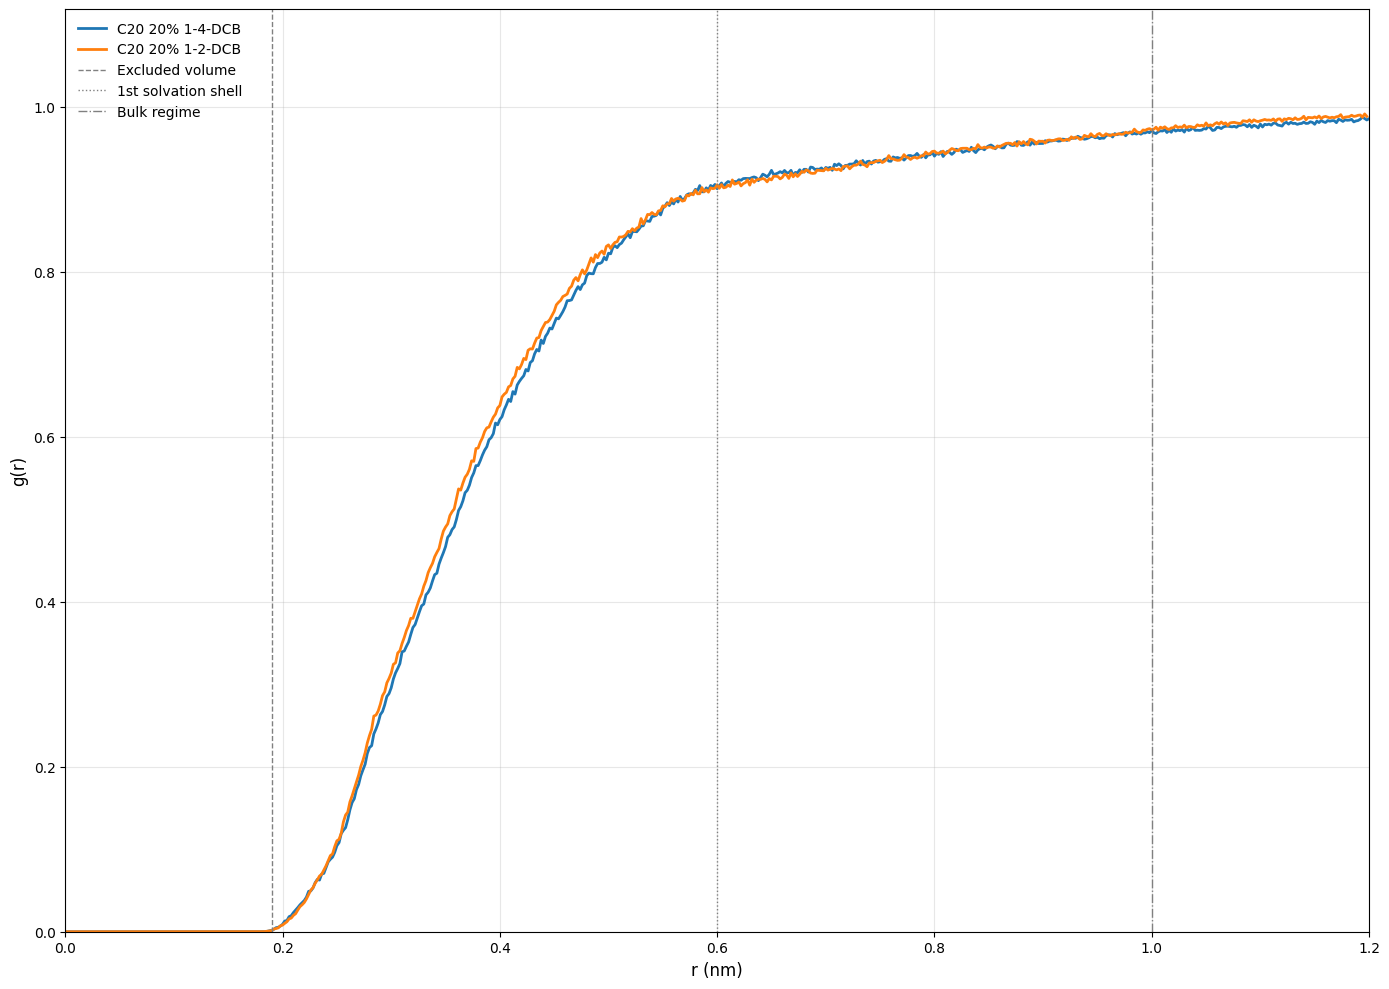

In [11]:
import matplotlib.pyplot as plt
import numpy as np

time1= np.array(time1)
rdf1= np.array(rdf1)    

plt.figure(figsize=(14, 10))

# RDF curve
# plt.plot(time1, rdf1, lw=2, label="C20 0% 1-4-DCB")
# plt.plot(time2, rdf2, lw=2, label="C20 10% 1-4-DCB")
plt.plot(time3, rdf3, lw=2, label="C20 20% 1-4-DCB")

# plt.plot(time4, rdf4, lw=2, label="0% 1-2-DCB")
# plt.plot(time5, rdf5, lw=2, label="C20 10% 1-2-DCB")
plt.plot(time6, rdf6, lw=2, label="C20 20% 1-2-DCB")
# Vertical lines for solvent zones
plt.axvline(0.19, color="gray", ls="--", lw=1, label="Excluded volume")
plt.axvline(0.60, color="gray", ls=":",  lw=1, label="1st solvation shell")
plt.axvline(1.00, color="gray", ls="-.", lw=1, label="Bulk regime")

# Zoom into the important region
plt.xlim(0.0, 1.2)

# Optional: emphasize RDF variation
plt.ylim(0.0, max(rdf1[(time1 >= 0) & (time1 <= 1.0)]) * 1.15)

# Axis labels with units
plt.xlabel("r (nm)", fontsize=12)
plt.ylabel("g(r)", fontsize=12)

# Grid helps a LOT for RDF interpretation
plt.grid(alpha=0.3)

# Legend (small, unobtrusive)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


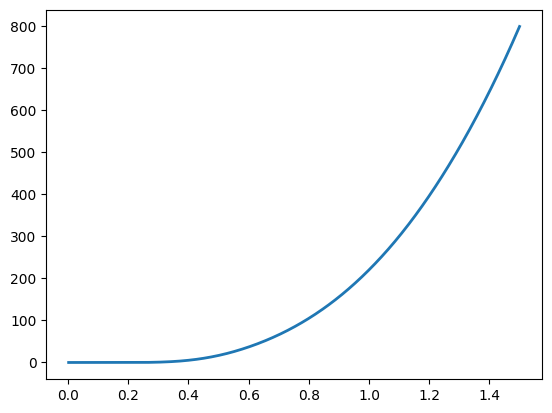

In [23]:
plt.plot(nm, cn, lw=2, label="Coordination Number LIG-DCB")
# plt.plot(nm2, cn2, lw=2, label="Coordination Number LIG-DCB 20%")